# Task
Создать и обучить сетку распознаванию крестиков или ноликов.

# Installation

**Особенности на MacOs M1:** 
1. На MacOs c M1 нужно установить пакет tenserflow-macos вместо стандартного tenserflow
1. Почему-то падает с ошибкой на методе load_img из pillow. Нужно pillow деинсталить и установить заново, перезапустив Jupter Kernel.

In [34]:
# Подключение класса для создания нейронной сети прямого распространения
from tensorflow.keras.models import Sequential 
# Подключение класса для создания полносвязного слоя
from tensorflow.keras.layers import Dense, Flatten
# Подключение оптимизатора
from tensorflow.keras.optimizers import Adam 
# Подключение утилит для to_categorical
from tensorflow.keras import utils 
# Подключение библиотеки для загрузки изображений
from tensorflow.keras.preprocessing import image 

import numpy as np
import os

# Подключение библиотек для отрисовки изображений
import matplotlib.pyplot as plt 
from PIL import Image 
# Вывод изображения в ноутбуке, а не в консоли или файле
%matplotlib inline 

In [67]:
# Переберем все файлы с картинками крестиков и картинками ноликов в каталоге.
# Преобразуем каждое в массив (20, 20) после открытия в режиме grayscale.
# Сложим все в x_train, а в y_train расставим метки - крстик или нолик.


base_dir = 'hw_pro' # Путь к директории с базой
x_train = []
y_train = []

img_height = 20
img_width = 20

for patch in ['0', 'Х']:
    for img in os.listdir(base_dir + '/' + patch):
        x_train.append(image.img_to_array(image.load_img(base_dir + '/' + patch + '/' + img,
                                                         target_size=(img_height, img_width),
                                                         color_mode='grayscale')))
        if patch == '0':
            y_train.append(0)
        else:
            y_train.append(1)

# Преобразование в numpy-массив загруженных изображений и меток классов
x_train = np.array(x_train)
y_train = np.array(y_train)

print('Размер массива x_train', x_train.shape)
print('Размер массива y_train', y_train.shape)

Размер массива x_train (102, 20, 20, 1)
Размер массива y_train (102,)


In [68]:
# Все картинки (20, 20, 1) векторизуем

# DK_INFO:
# Первое измерение (это наши картинки) оставляем такоже длины
# Остальные преобразуем в вектор. -1 означет, что reshape сам определит размер
# Если нужно просто все в вектор превратить есть метод .reval().
# Но сейчас он не подходит, потому что тогда все картинки "склеятся" вместе
x_train2 = x_train.reshape(x_train.shape[0], -1)  

# Нормируем значения цветов 0-255
# DK_INFO: Говорят если ненормировать, то нейронка будет хуже обучается
x_train2 = x_train2.astype('float32') / 255.

# DK_TODO: Кто-то нормализует с помощью встроенной в keras функции .normalize. В чем отличие?
# x_train2 = utils.normalize(x_train2, axis=0)

x_train2

array([[1.        , 1.        , 0.9882353 , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.98039216, 1.        , 1.        , ..., 1.        , 0.972549  ,
        1.        ],
       ...,
       [1.        , 0.99215686, 1.        , ..., 1.        , 0.99607843,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.9843137 , 1.        ,
        1.        ],
       [1.        , 0.9882353 , 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

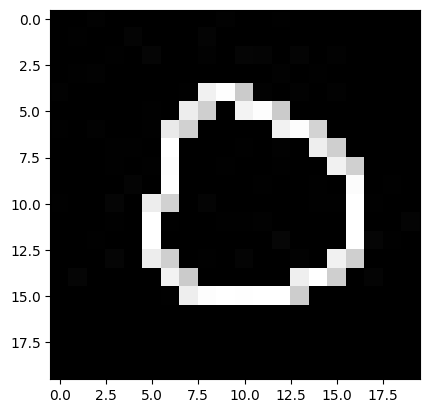

In [33]:
# Посмотрим вектор на картинке
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

In [69]:
# One Hot Encoding

# DK_INFO:
# One Hot Encoding - преобразует вектор результирующих классов в матрицу векторов 
# с вероятностями каждого класса для каждой входной картинки

CLASS_COUNT = 2
y_train2 = utils.to_categorical(y_train, CLASS_COUNT)
y_train2.shape

(102, 2)

In [70]:
# Разделим данные на train и test
x_test = x_train2[92:92+10]
y_test = y_train2[92:92+10]

x_train2 = x_train2[:-10]
y_train2 = y_train2[:-10]

In [71]:
# Создаем модель

# Создание последовательной модели
model = Sequential()

# Вроде с помощью этого слоя можно избежать reshape. Но у меня не получилось, если просто его добавить и
# попробовать скомпилить и обучить сетку на исходных тензорах x_train и y_train 
# model.add(Flatten()) 

# Добавление полносвязного слоя на 800 нейронов с relu-активацией
model.add(Dense(800, input_dim=400, activation='relu')) 

# Добавление полносвязного слоя на 400 нейронов с relu-активацией
model.add(Dense(400, activation='relu')) 

# Добавление полносвязного слоя с количеством нейронов по числу классов с softmax-активацией
model.add(Dense(CLASS_COUNT, activation='softmax')) 

# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(x_train2.shape) 
model.summary()

# DK_TODO:
# 1. Почему Sequential? Какие еще можно применить?
# 2. Почему первый слой Dense?
# 3. Почему в первом слое именно 800 нейронов? Не 2 или 10000?
# 4. Зачем задавать явно input_dim=400 (по длине вектора обучения)? 
# 5. Почему без этого параметра обучается хуже?
# 6. Почему функция активации именно relu? Какие еще применимы здесь и вообще бывают?
# 7. Почему второй слой тоже Dense?
# 8. Как выбирать количество нейронов в нем?
# 9. Почему слоев всего 2, а не 10?
# 10. Почему в результируещем слое активация softmax?
# 11. Почему функция loss='categorical_crossentropy'?
# 12. Почему оптимизатор именно adam? Какие еще применимы здесь и в принципе?
# 13. Почему в metrics только accuracy? Другием не нужны?
# 14. Как избавиться от reshape просто добавивь Flatten() слой?


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 800)               320800    
                                                                 
 dense_21 (Dense)            (None, 400)               320400    
                                                                 
 dense_22 (Dense)            (None, 2)                 802       
                                                                 
Total params: 642,002
Trainable params: 642,002
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Обучение
model.fit(x_train2, y_train2, epochs=20, verbose=1)

# DK_TODO:
# 1. Почему 15 эпох?
# 2. Почему verbose=1?

Epoch 1/20
3/3 [==============================] - 0s 2ms/step - loss: 1.1156 - accuracy: 0.5109
Epoch 2/20
3/3 [==============================] - 0s 2ms/step - loss: 0.4740 - accuracy: 0.7826
Epoch 3/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3858 - accuracy: 0.8804
Epoch 4/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3670 - accuracy: 0.7935
Epoch 5/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3094 - accuracy: 0.9130
Epoch 6/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2191 - accuracy: 0.9565
Epoch 7/20
3/3 [==============================] - 0s 2ms/step - loss: 0.1672 - accuracy: 0.9674
Epoch 8/20
3/3 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.9783
Epoch 9/20
3/3 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.9674
Epoch 10/20
3/3 [==============================] - 0s 2ms/step - loss: 0.0767 - accuracy: 1.0000
Epoch 11/20
3/3 [======================

In [73]:
# Проверим модель на тестовых данных

r = model.evaluate(x_test, y_test)


1/1 [==============================] - 0s 69ms/step - loss: 0.0117 - accuracy: 1.0000
